In [1]:
""" Mount Google Drive to Google Colab Notebook
""" 
from google.colab import drive
drive.mount('/content/drive')
""" Change present working directory
"""
%cd /content/drive/MyDrive/CS5260/Github/

Mounted at /content/drive
/content/drive/MyDrive/CS5260/Github


In [2]:
%cd CS5260
!ls

/content/drive/MyDrive/CS5260/Github/CS5260
 assets					 data	      QA.txt
 Assignments				 explore.py   setup.sh
'Copy of CS5260Project_Colossai.ipynb'	 logs	      src
 CS5260Project.ipynb			 proposals


In [3]:
import numpy as np
import pandas as pd
import skimage.io as io
import matplotlib.pyplot as plt
import torch.utils.data as data
import torch
import json
import os
import nltk
from tqdm import tqdm
tqdm.pandas()
nltk.download('stopwords')
nltk.download('punkt')
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
%load_ext autoreload
%autoreload
from src.utils.data_loader import get_loader

In [5]:
with open('./data/vaild_dataset.json', 'r') as outfile:
  product_info = pd.read_json(json.load(outfile), orient="records")
product_info.head()

title  \
0  14k Yellow Gold 3mm Half Round Plain Wedding Band   
1         14k Gold 4mm Half Round Plain Wedding Band   
2  18k Yellow Gold 7mm Comfort Fit Milgrain Plain...   
3    Sterling Silver Gold Plated Blue Topaz Earrings   
4                    Kenneth Cole_Watch Watch KC3489   

                                     imageURLHighRes  \
0  https://images-na.ssl-images-amazon.com/images...   
1  https://images-na.ssl-images-amazon.com/images...   
2  https://images-na.ssl-images-amazon.com/images...   
3  https://images-na.ssl-images-amazon.com/images...   
4  https://images-na.ssl-images-amazon.com/images...   

                                         description     perCategory  valid  
0  [With its smooth surface and high polish, this...  AMAZON_FASHION   True  
1  [With its smooth surface and high polish, this...  AMAZON_FASHION   True  
2  [With its smooth surface and high polish, this...  AMAZON_FASHION   True  
3  [Gemstone Specifications: Number of Stones - 2...  AMAZON_FASHION   True  
4  [Dynamic Kenneth Cole style... modern, contemp...  AMAZON_FASHION   True

In [6]:
product_info["perCategory"].unique()

array(['AMAZON_FASHION', 'All_Beauty', 'Appliances',
       'Arts_Crafts_and_Sewing', 'Automotive', 'Books', 'CDs_and_Vinyl',
       'Cell_Phones_and_Accessories', 'Clothing_Shoes_and_Jewelry',
       'Digital_Music', 'Electronics', 'Gift_Cards',
       'Grocery_and_Gourmet_Food', 'Home_and_Kitchen',
       'Industrial_and_Scientific', 'Luxury_Beauty',
       'Magazine_Subscriptions', 'Movies_and_TV', 'Musical_Instruments',
       'Office_Products', 'Patio_Lawn_and_Garden', 'Pet_Supplies',
       'Prime_Pantry', 'Software', 'Sports_and_Outdoors',
       'Tools_and_Home_Improvement', 'Toys_and_Games', 'Video_Games'],
      dtype=object)

In [7]:
product_info = product_info[product_info.valid == True]
product_info = product_info[product_info["perCategory"].isin(["AMAZON_FASHION", 'All_Beauty', 'Clothing_Shoes_and_Jewelry'])].reset_index(drop=True)
product_info.shape

(603, 5)

14k Yellow and White Gold Engraved Plain Wedding Band
https://images-na.ssl-images-amazon.com/images/I/41935SJ3HKL.jpg
AMAZON_FASHION


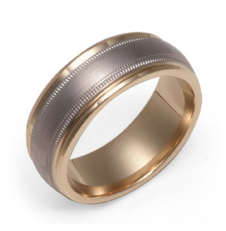

In [8]:
idex = 10
img_url = product_info.loc[idex,"imageURLHighRes"]
caption = product_info.loc[idex,"title"]
Category = product_info.loc[idex,"perCategory"]
print(caption)
print(img_url)
print(Category)
I = io.imread(img_url)
plt.axis('off')
plt.imshow(I)
plt.show()

In [9]:
from torchvision import transforms
from sklearn.preprocessing import OneHotEncoder

image_dict = product_info["imageURLHighRes"].to_dict()
caption_dict = product_info["title"].to_dict()
category_dict = product_info["perCategory"].to_dict()
onehot_cat = OneHotEncoder().fit_transform(np.array([*category_dict.values()], dtype=object).reshape(-1, 1)).toarray()

# Define a transform to pre-process the training images.
transform_train = transforms.Compose([ 
    transforms.Resize(500),                          # smaller edge of image resized to 256
    transforms.Resize((320,320)),                      # get 224x224 crop from random location
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Set the minimum word count threshold.
vocab_threshold = 5

mode = "train"

# Specify the batch size.
# we will pass 10 images at a time. So, m = 10
batch_size = 10

In [10]:
%load_ext autoreload
%autoreload
from src.utils.data_loader import get_loader


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
data_loader = get_loader(product_info,
                        transform=transform_train,
                        mode='train',
                        image_type="imageURLHighRes",
                        batch_size=batch_size,
                        vocab_threshold=vocab_threshold,
                        vocab_from_file=False)

print('The shape of first image:', data_loader.dataset[0][0].shape)
print('Total number of tokens in vocabulary:', len(data_loader.dataset.vocab))

# Randomly sample a caption length, and sample indices with that length.
indices = data_loader.dataset.get_indices()
print('sampled indices:', indices)

# Create and assign a batch sampler to retrieve a batch with the sampled indices.
new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
data_loader.batch_sampler.sampler = new_sampler
    
# Obtain the batch.
images, onehot_cat, captions = next(iter(data_loader))
    
print('images.shape:', images.shape)
print('onehot_cat.shape:', onehot_cat.shape)
print('captions.shape:', captions.shape)

[0/603] Tokenizing captions...
Obtaining caption lengths...


100%|██████████| 603/603 [00:00<00:00, 3162.93it/s]


The shape of first image: torch.Size([3, 320, 320])
Total number of tokens in vocabulary: 374
sampled indices: [28, 174, 528, 535, 171, 171, 157, 533, 173, 157]
images.shape: torch.Size([10, 3, 320, 320])
onehot_cat.shape: torch.Size([10, 1, 3])
captions.shape: torch.Size([10, 16])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


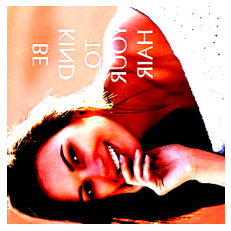

In [12]:
plt.axis('off')
plt.imshow(images[0].detach().T)
plt.show()

# Training Setup 

In [13]:
import torch
import torch.nn as nn
from torchvision import transforms
import numpy as np
import sys
import os
import math
from sklearn.model_selection import train_test_split
import torch.utils.data as data
import nltk
from nltk.translate.bleu_score import corpus_bleu
nltk.download('punkt')

%load_ext autoreload
%autoreload
from src.utils.data_loader import get_loader
from src.models.CNN_Encoder import EncoderCNN
from src.models.RNN_Decoder import DecoderRNN
from src.models.MLP_Encoder import MlpEncoder
from src.utils.utils_trainer import get_batch_caps, get_hypothesis, adjust_learning_rate

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Training Model

In [16]:
def train(epoch, 
          encoder,
          decoder,
          encoder_optimizer,
          decoder_optimizer,
          criterion, 
          total_step, 
          num_epochs, 
          data_loader, 
          write_file, 
          save_every = 1):
    """ Train function for a single epoch. 
    Arguments: 
    ----------
    - epoch - number of current epoch
    - encoder - model's Encoder
    - decoder - model's Decoder
    - optimizer - model's optimizer (Adam in our case)
    - criterion - loss function to optimize
    - num_epochs - total number of epochs
    - data_loader - specified data loader (for training, validation or test)
    - write_file - file to write the training logs
    
    """
    epoch_loss = 0.0
    epoch_perplex = 0.0
    
    for i_step in range(1, total_step+1):
        # training mode on
        encoder.train() # no fine-tuning for Encoder
        # mlp.train()
        decoder.train()
        
        # Randomly sample a caption length, and sample indices with that length.
        indices = data_loader.dataset.get_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        data_loader.batch_sampler.sampler = new_sampler
        
        # Obtain the batch.
        images, onehot_cat, captions = next(iter(data_loader))
        # target captions, excluding the first word
        captions_target = captions[:, 1:].to(device) 
        # captions for training without the last word
        captions_train = captions[:, :-1].to(device)

        # Move batch of images and captions to GPU if CUDA is available.
        images = images.to(device)

        # onehot_cat = onehot_cat.to(device)
        
        # Zero the gradients.
        decoder.zero_grad()
        # mlp.zero_grad()
        encoder.zero_grad()
        
        # Pass the inputs through the CNN-RNN model.
        features = encoder(images)

        outputs, atten_weights = decoder(captions= captions_train,
                                         features = features)
        
        # Calculate the batch loss.
        loss = criterion(outputs.view(-1, vocab_size), captions_target.reshape(-1))
        
        # Backward pass.
        loss.backward()
        
        # Update the parameters in the optimizer.
        encoder_optimizer.step()
        decoder_optimizer.step()
        
        perplex = np.exp(loss.item())
        epoch_loss += loss.item()
        epoch_perplex += perplex
        
        stats = 'Epoch train: [%d/%d], Step train: [%d/%d], Loss train: %.4f, Perplexity train: %5.4f' % (epoch, num_epochs, i_step, total_step, loss.item(), perplex)
        
        # Print training statistics (on same line).
        print('\r' + stats, end="")
        sys.stdout.flush()
        
        # Print training statistics to file.
        write_file.write(stats + '\n')
        write_file.flush()
        
        # Print training statistics (on different line).
        if i_step % print_every == 0:
            print('\r' + stats)
        
    epoch_loss_avg = epoch_loss / total_step
    epoch_perp_avg = epoch_perplex / total_step
    
    print('\r')
    print('Epoch train:', epoch)
    print('\r' + 'Avg. Loss train: %.4f, Avg. Perplexity train: %5.4f' % (epoch_loss_avg, epoch_perp_avg), end="")
    print('\r')
    
    # Save the weights.
    # if epoch % save_every == 0:
    #     torch.save(decoder.state_dict(), os.path.join('./models_new', 'decoder-%d.pkl' % epoch))
    #     torch.save(encoder.state_dict(), os.path.join('./models_new', 'encoder-%d.pkl' % epoch))

In [17]:
def validate(epoch, 
             encoder, 
             decoder, 
             encoder_optimizer, 
             decoder_optimizer, 
             criterion, 
             total_step, num_epochs, data_loader, write_file, bleu_score_file):
    """ Validation function for a single epoch. 
    Arguments: 
    ----------
    - epoch - number of current epoch
    - encoder - model's Encoder (evaluation)
    - decoder - model's Decoder (evaluation)
    - optimizer - model's optimizer (Adam in our case)
    - criterion - optimized loss function
    - num_epochs - total number of epochs
    - data_loader - specified data loader (for training, validation or test)
    - write_file - file to write the validation logs
    """
    epoch_loss = 0.0
    epoch_perplex = 0.0
    references = []
    hypothesis = []
      
    for i_step in range(1, total_step+1):
        # evaluation of encoder and decoder
        encoder.eval()
        decoder.eval()
        val_images, val_onehot_cat, val_captions, caps_all = next(iter(data_loader))
        
        val_captions_target = val_captions[:, 1:].to(device) 
        val_captions = val_captions[:, :-1].to(device)
        val_images = val_images.to(device)
    
        
        features_val = encoder(val_images)
        outputs_val, atten_weights_val = decoder(captions= val_captions,
                                         features = features_val)
        loss_val = criterion(outputs_val.view(-1, vocab_size), 
                             val_captions_target.reshape(-1))
        
        # preprocess captions and add them to the list
        caps_processed = get_batch_caps(caps_all, batch_size=batch_size)
        references.append(caps_processed)
        # get corresponding indicies from predictions
        # and form hypothesis from output
        terms_idx = torch.max(outputs_val, dim=2)[1]
        hyp_list = get_hypothesis(terms_idx, data_loader=data_loader)
        hypothesis.append(hyp_list)
        
        perplex = np.exp(loss_val.item())
        epoch_loss += loss_val.item()
        epoch_perplex += perplex
        
        stats = 'Epoch valid: [%d/%d], Step valid: [%d/%d], Loss valid: %.4f, Perplexity valid: %5.4f' % (epoch, num_epochs, i_step, total_step, loss_val.item(), perplex)
        
        # Print training statistics (on same line).
        print('\r' + stats, end="")
        sys.stdout.flush()
        
        # Print training statistics to file.
        write_file.write(stats + '\n')
        write_file.flush()
        
        # Print training statistics (on different line).
        if i_step % print_every == 0:
            print('\r' + stats)
    
    epoch_loss_avg = epoch_loss / total_step
    epoch_perp_avg = epoch_perplex / total_step
            
    # prepare the proper shape for computing BLEU scores
    references = np.array(references).reshape(total_step*batch_size, -1)
    #hyps = np.array(hypothesis).reshape(total_step*batch_size, -1)
    hyps = np.concatenate(np.array(hypothesis))
        
    bleu_1 = corpus_bleu(references, hyps, weights = (1.0, 0, 0, 0))
    bleu_2 = corpus_bleu(references, hyps, weights = (0.5, 0.5, 0, 0))
    bleu_3 = corpus_bleu(references, hyps, weights = (1.0/3.0, 1.0/3.0, 1.0/3.0, 0))
    bleu_4 = corpus_bleu(references, hyps, weights = (0.25, 0.25, 0.25, 0.25))
    # append individual n_gram scores
    #bleu_score_list.append((bleu_1, bleu_2, bleu_3, bleu_4))
    
    print('\r')
    print('Epoch valid:', epoch)
    epoch_stat = 'Avg. Loss valid: %.4f, Avg. Perplexity valid: %5.4f, \
    BLEU-1: %.2f, BLEU-2: %.2f, BLEU-3: %.2f, BLEU-4: %.2f' % (epoch_loss_avg, epoch_perp_avg, bleu_1, bleu_2, bleu_3, bleu_4)
    
    print('\r' + epoch_stat, end="")
    print('\r')
    
    bleu_score_file.write(epoch_stat + '\n')
    bleu_score_file.flush()
    return bleu_1, bleu_2, bleu_3, bleu_4

In [18]:
batch_size = 10          # batch size, change to 64
vocab_threshold = 3        # minimum word count threshold
vocab_from_file = True    # if True, load existing vocab file
embed_size = 125           # dimensionality of image and word embeddings
hidden_size = 512          # number of features in hidden state of the RNN decoder
num_features = 2048        # number of feature maps, produced by Encoder
num_epochs = 200               # number of training epochs
save_every = 1             # determines frequency of saving model weights
print_every = 100          # determines window for printing average loss

log_train = './logs/training_log.txt'       # name of files with saved training loss and perplexity
log_val = './logs/validation_log.txt'
bleu = './logs/bleu.txt'

In [19]:
train_df, test_df = train_test_split(product_info, test_size=0.2)
train_df.reset_index(drop=True,inplace=True)
test_df.reset_index(drop=True,inplace=True)


transform_train = transforms.Compose([ 
    transforms.Resize(500),                          # smaller edge of image resized to 256
    transforms.Resize((320,320)),                      # get 224x224 crop from random location
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Build data loader.
data_loader = get_loader(train_df,
                         transform=transform_train,
                         mode='train',
                         image_type="imageURLHighRes",
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=False)

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Setup the transforms
transform_test = transforms.Compose([ 
    transforms.Resize((320,320)),                   # smaller edge of image resized to 500
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Create the data loader.

valid_data_loader = get_loader(test_df,
                               transform=transform_train,
                               mode='valid',
                               image_type="imageURLHighRes",
                               batch_size=batch_size)


total_step_valid = math.ceil(len(valid_data_loader.dataset.caption_lengths) / valid_data_loader.batch_sampler.batch_size)
total_step_valid

[0/482] Tokenizing captions...
Obtaining caption lengths...


100%|██████████| 482/482 [00:00<00:00, 7632.40it/s]


Vocabulary successfully loaded from vocab.pkl file!
Obtaining caption lengths...


100%|██████████| 121/121 [00:00<00:00, 5389.70it/s]


13

In [20]:
# Initialize the encoder and decoder. 
encoder = EncoderCNN()
decoder = DecoderRNN(num_features = num_features, 
                     embedding_dim = embed_size, 
                     hidden_dim = hidden_size, 
                     vocab_size = vocab_size)

# Move models to GPU if CUDA is available. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

DecoderRNN(
  (embeddings): Embedding(455, 125)
  (lstm): LSTMCell(2173, 512)
  (fc): Linear(in_features=512, out_features=455, bias=True)
  (attention): TranslateAttention(
    (W_a): Linear(in_features=2048, out_features=512, bias=True)
    (U_a): Linear(in_features=512, out_features=512, bias=True)
    (v_a): Linear(in_features=512, out_features=1, bias=True)
  )
  (drop): Dropout(p=0.5, inplace=False)
  (init_h): Linear(in_features=2048, out_features=512, bias=True)
  (init_c): Linear(in_features=2048, out_features=512, bias=True)
)

In [21]:
print(device)
# Define the loss function. 
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

#params = list(decoder.parameters()) + list(encoder.parameters()) 
params = list(decoder.parameters())

# TODO #4: Define the optimizer.
grad_clip = 5.  # clip gradients at an absolute value of
alpha_c = 1.  # regularization parameter for 'doubly stochastic attention', as in the paper

encoder_lr = 1e-4  # learning rate for encoder if fine-tuning
encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),lr=encoder_lr)

decoder_lr = 1.2e-4  # learning rate for decoder
decoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()),lr=decoder_lr)

fine_tune_encoder = False  # fine-tune encoder?
checkpoint = None  # path to checkpoint, None if none

# Set the total number of training steps per epoch.
total_step = math.ceil(len(data_loader.dataset.caption_lengths) / data_loader.batch_sampler.batch_size)

cpu


In [ ]:
from datetime import datetime
now = datetime.now()
current_time = now.strftime("%Y-%m-%d-%H-%M-%S")
if not os.path.exists(f'../models_new/{current_time}'):
  os.makedirs(f'../models_new/{current_time}')

# Open the training log file.
file_train = open(log_train, 'w')
file_val = open(log_val, 'w')
bleu_score_file = open(bleu, 'w')

# store BLEU scores in list 
bleu_scores = []
total_step_valid = math.ceil(len(valid_data_loader.dataset.caption_lengths) / valid_data_loader.batch_sampler.batch_size)
epochs_since_improvement = 0
best_bleu = 0.

for epoch in range(0, num_epochs+1):
    # Decay learning rate if there is no improvement for 8 consecutive epochs, and terminate training after 20
    if epochs_since_improvement == 30:
        break
    if epochs_since_improvement > 0 and epochs_since_improvement % 20 == 0:
        adjust_learning_rate(decoder_optimizer, 0.8)
        if fine_tune_encoder:
            adjust_learning_rate(encoder_optimizer, 0.8)

    train(epoch, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, total_step, num_epochs =num_epochs,
          data_loader = data_loader,
          write_file = file_train, 
          save_every = 1)
    
    bleus= validate(epoch, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, 
                                             total_step = total_step_valid, 
                                             num_epochs = num_epochs, 
                                             data_loader = valid_data_loader, write_file=file_val, bleu_score_file=bleu_score_file)
    # Check if there was an improvement
    is_best = sum(bleus)/4 > best_bleu
    best_bleu = max(sum(bleus)/4, best_bleu)
    if not is_best:
        epochs_since_improvement += 1
        print("\nEpochs since last improvement: %d\n" % (epochs_since_improvement,))
    else:
        torch.save(decoder.state_dict(), os.path.join(f'../models_new/{current_time}', 'decoder-%d.pkl' % epoch))
        torch.save(encoder.state_dict(), os.path.join(f'../models_new/{current_time}', 'encoder-%d.pkl' % epoch))
        epochs_since_improvement = 0
    
file_train.close()
file_val.close()
bleu_score_file.close()

Epoch train: [0/200], Step train: [49/49], Loss train: 4.6944, Perplexity train: 109.3317
Epoch train: 0
Avg. Loss train: 5.1701, Avg. Perplexity train: 217.7237
Epoch valid: [0/200], Step valid: [13/13], Loss valid: 2.7356, Perplexity valid: 15.4183

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



Epoch valid: 0
Avg. Loss valid: 2.7392, Avg. Perplexity valid: 15.4743,     BLEU-1: 0.00, BLEU-2: 0.00, BLEU-3: 0.00, BLEU-4: 0.00

Epochs since last improvement: 1

Epoch train: [1/200], Step train: [49/49], Loss train: 3.4860, Perplexity train: 32.6537
Epoch train: 1
Avg. Loss train: 4.6376, Avg. Perplexity train: 141.2530
Epoch valid: [1/200], Step valid: [13/13], Loss valid: 2.6541, Perplexity valid: 14.2116

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 1
Avg. Loss valid: 2.6437, Avg. Perplexity valid: 14.0655,     BLEU-1: 0.08, BLEU-2: 0.28, BLEU-3: 0.43, BLEU-4: 0.53
Epoch train: [2/200], Step train: [49/49], Loss train: 3.6034, Perplexity train: 36.7243
Epoch train: 2
Avg. Loss train: 4.2763, Avg. Perplexity train: 97.4591
Epoch valid: [2/200], Step valid: [13/13], Loss valid: 2.7686, Perplexity valid: 15.9363

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 2
Avg. Loss valid: 2.7731, Avg. Perplexity valid: 16.0086,     BLEU-1: 0.09, BLEU-2: 0.30, BLEU-3: 0.45, BLEU-4: 0.55
Epoch train: [3/200], Step train: [49/49], Loss train: 3.7028, Perplexity train: 40.5623
Epoch train: 3
Avg. Loss train: 4.2179, Avg. Perplexity train: 121.0025
Epoch valid: [3/200], Step valid: [13/13], Loss valid: 2.4024, Perplexity valid: 11.0492

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 3
Avg. Loss valid: 2.4023, Avg. Perplexity valid: 11.0485,     BLEU-1: 0.08, BLEU-2: 0.28, BLEU-3: 0.43, BLEU-4: 0.53

Epochs since last improvement: 1

Epoch train: [4/200], Step train: [49/49], Loss train: 2.3451, Perplexity train: 10.4340
Epoch train: 4
Avg. Loss train: 4.0524, Avg. Perplexity train: 83.3925
Epoch valid: [4/200], Step valid: [13/13], Loss valid: 2.4968, Perplexity valid: 12.1435

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 4
Avg. Loss valid: 2.4857, Avg. Perplexity valid: 12.0103,     BLEU-1: 0.09, BLEU-2: 0.30, BLEU-3: 0.45, BLEU-4: 0.54

Epochs since last improvement: 2

Epoch train: [5/200], Step train: [49/49], Loss train: 3.3375, Perplexity train: 28.1477
Epoch train: 5
Avg. Loss train: 3.9225, Avg. Perplexity train: 87.5906
Epoch valid: [5/200], Step valid: [13/13], Loss valid: 2.7036, Perplexity valid: 14.9331

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 5
Avg. Loss valid: 2.6848, Avg. Perplexity valid: 14.6568,     BLEU-1: 0.18, BLEU-2: 0.43, BLEU-3: 0.57, BLEU-4: 0.65
Epoch train: [6/200], Step train: [49/49], Loss train: 3.4680, Perplexity train: 32.0736
Epoch train: 6
Avg. Loss train: 3.5150, Avg. Perplexity train: 51.0173
Epoch valid: [6/200], Step valid: [13/13], Loss valid: 3.2414, Perplexity valid: 25.5703

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 6
Avg. Loss valid: 3.2154, Avg. Perplexity valid: 24.9175,     BLEU-1: 0.20, BLEU-2: 0.44, BLEU-3: 0.58, BLEU-4: 0.67
Epoch train: [7/200], Step train: [49/49], Loss train: 3.3562, Perplexity train: 28.6795
Epoch train: 7
Avg. Loss train: 3.3768, Avg. Perplexity train: 40.6491
Epoch valid: [7/200], Step valid: [13/13], Loss valid: 2.6006, Perplexity valid: 13.4715

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 7
Avg. Loss valid: 2.5993, Avg. Perplexity valid: 13.4557,     BLEU-1: 0.24, BLEU-2: 0.49, BLEU-3: 0.62, BLEU-4: 0.70
Epoch train: [8/200], Step train: [49/49], Loss train: 1.8136, Perplexity train: 6.1322
Epoch train: 8
Avg. Loss train: 3.0295, Avg. Perplexity train: 26.4379
Epoch valid: [8/200], Step valid: [13/13], Loss valid: 2.7631, Perplexity valid: 15.8483

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 8
Avg. Loss valid: 2.7760, Avg. Perplexity valid: 16.0564,     BLEU-1: 0.22, BLEU-2: 0.47, BLEU-3: 0.60, BLEU-4: 0.68

Epochs since last improvement: 1

Epoch train: [9/200], Step train: [49/49], Loss train: 2.3920, Perplexity train: 10.9357
Epoch train: 9
Avg. Loss train: 3.1896, Avg. Perplexity train: 46.3538
Epoch valid: [9/200], Step valid: [13/13], Loss valid: 2.9483, Perplexity valid: 19.0733

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 9
Avg. Loss valid: 2.9879, Avg. Perplexity valid: 19.8472,     BLEU-1: 0.26, BLEU-2: 0.51, BLEU-3: 0.64, BLEU-4: 0.71
Epoch train: [10/200], Step train: [49/49], Loss train: 5.3948, Perplexity train: 220.2647
Epoch train: 10
Avg. Loss train: 2.8692, Avg. Perplexity train: 26.1535
Epoch valid: [10/200], Step valid: [13/13], Loss valid: 2.8994, Perplexity valid: 18.1630

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 10
Avg. Loss valid: 2.9071, Avg. Perplexity valid: 18.3038,     BLEU-1: 0.23, BLEU-2: 0.48, BLEU-3: 0.61, BLEU-4: 0.69

Epochs since last improvement: 1

Epoch train: [11/200], Step train: [49/49], Loss train: 3.1417, Perplexity train: 23.1432
Epoch train: 11
Avg. Loss train: 2.7906, Avg. Perplexity train: 28.1783
Epoch valid: [11/200], Step valid: [13/13], Loss valid: 2.8109, Perplexity valid: 16.6251

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 11
Avg. Loss valid: 2.8021, Avg. Perplexity valid: 16.4812,     BLEU-1: 0.26, BLEU-2: 0.51, BLEU-3: 0.64, BLEU-4: 0.71
Epoch train: [12/200], Step train: [49/49], Loss train: 2.0355, Perplexity train: 7.6559
Epoch train: 12
Avg. Loss train: 2.5731, Avg. Perplexity train: 22.1980
Epoch valid: [12/200], Step valid: [13/13], Loss valid: 3.1346, Perplexity valid: 22.9803

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 12
Avg. Loss valid: 3.1493, Avg. Perplexity valid: 23.3236,     BLEU-1: 0.26, BLEU-2: 0.51, BLEU-3: 0.64, BLEU-4: 0.71

Epochs since last improvement: 1

Epoch train: [13/200], Step train: [49/49], Loss train: 2.0147, Perplexity train: 7.4986
Epoch train: 13
Avg. Loss train: 2.4726, Avg. Perplexity train: 28.3948
Epoch valid: [13/200], Step valid: [13/13], Loss valid: 2.4662, Perplexity valid: 11.7778

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 13
Avg. Loss valid: 2.4500, Avg. Perplexity valid: 11.5905,     BLEU-1: 0.24, BLEU-2: 0.49, BLEU-3: 0.62, BLEU-4: 0.70

Epochs since last improvement: 2

Epoch train: [14/200], Step train: [49/49], Loss train: 2.4839, Perplexity train: 11.9877
Epoch train: 14
Avg. Loss train: 2.3116, Avg. Perplexity train: 13.8198
Epoch valid: [14/200], Step valid: [13/13], Loss valid: 2.7387, Perplexity valid: 15.4666

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 14
Avg. Loss valid: 2.6950, Avg. Perplexity valid: 14.8092,     BLEU-1: 0.24, BLEU-2: 0.49, BLEU-3: 0.62, BLEU-4: 0.70

Epochs since last improvement: 3

Epoch train: [15/200], Step train: [49/49], Loss train: 2.8625, Perplexity train: 17.5045
Epoch train: 15
Avg. Loss train: 2.3072, Avg. Perplexity train: 15.3686
Epoch valid: [15/200], Step valid: [13/13], Loss valid: 3.4136, Perplexity valid: 30.3737

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 15
Avg. Loss valid: 3.3466, Avg. Perplexity valid: 28.4280,     BLEU-1: 0.41, BLEU-2: 0.64, BLEU-3: 0.75, BLEU-4: 0.80
Epoch train: [16/200], Step train: [49/49], Loss train: 1.6875, Perplexity train: 5.4058
Epoch train: 16
Avg. Loss train: 2.4530, Avg. Perplexity train: 18.6526
Epoch valid: [16/200], Step valid: [13/13], Loss valid: 3.7683, Perplexity valid: 43.3072

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 16
Avg. Loss valid: 3.7768, Avg. Perplexity valid: 43.7040,     BLEU-1: 0.33, BLEU-2: 0.12, BLEU-3: 0.25, BLEU-4: 0.35

Epochs since last improvement: 1

Epoch train: [17/200], Step train: [49/49], Loss train: 3.7451, Perplexity train: 42.3147
Epoch train: 17
Avg. Loss train: 2.1129, Avg. Perplexity train: 10.6664
Epoch valid: [17/200], Step valid: [13/13], Loss valid: 2.9526, Perplexity valid: 19.1560

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 17
Avg. Loss valid: 2.9392, Avg. Perplexity valid: 18.9094,     BLEU-1: 0.28, BLEU-2: 0.53, BLEU-3: 0.65, BLEU-4: 0.73

Epochs since last improvement: 2

Epoch train: [18/200], Step train: [49/49], Loss train: 2.9149, Perplexity train: 18.4462
Epoch train: 18
Avg. Loss train: 2.1238, Avg. Perplexity train: 12.7474
Epoch valid: [18/200], Step valid: [13/13], Loss valid: 3.1049, Perplexity valid: 22.3079

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 18
Avg. Loss valid: 3.1315, Avg. Perplexity valid: 22.9139,     BLEU-1: 0.28, BLEU-2: 0.53, BLEU-3: 0.65, BLEU-4: 0.73

Epochs since last improvement: 3

Epoch train: [19/200], Step train: [49/49], Loss train: 1.4369, Perplexity train: 4.2076
Epoch train: 19
Avg. Loss train: 2.2091, Avg. Perplexity train: 16.1584
Epoch valid: [19/200], Step valid: [13/13], Loss valid: 3.0689, Perplexity valid: 21.5172

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 19
Avg. Loss valid: 3.0904, Avg. Perplexity valid: 21.9927,     BLEU-1: 0.24, BLEU-2: 0.49, BLEU-3: 0.62, BLEU-4: 0.70

Epochs since last improvement: 4

Epoch train: [20/200], Step train: [49/49], Loss train: 0.8800, Perplexity train: 2.4109
Epoch train: 20
Avg. Loss train: 1.8198, Avg. Perplexity train: 7.5464
Epoch valid: [20/200], Step valid: [13/13], Loss valid: 2.9561, Perplexity valid: 19.2233

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 20
Avg. Loss valid: 2.9278, Avg. Perplexity valid: 18.6932,     BLEU-1: 0.16, BLEU-2: 0.40, BLEU-3: 0.55, BLEU-4: 0.64

Epochs since last improvement: 5

Epoch train: [21/200], Step train: [49/49], Loss train: 1.5455, Perplexity train: 4.6903
Epoch train: 21
Avg. Loss train: 1.8562, Avg. Perplexity train: 9.7657
Epoch valid: [21/200], Step valid: [13/13], Loss valid: 3.4643, Perplexity valid: 31.9528

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 21
Avg. Loss valid: 3.4942, Avg. Perplexity valid: 32.9360,     BLEU-1: 0.20, BLEU-2: 0.07, BLEU-3: 0.18, BLEU-4: 0.27

Epochs since last improvement: 6

Epoch train: [22/200], Step train: [49/49], Loss train: 1.7240, Perplexity train: 5.6070
Epoch train: 22
Avg. Loss train: 1.6919, Avg. Perplexity train: 8.6647
Epoch valid: [22/200], Step valid: [13/13], Loss valid: 3.2680, Perplexity valid: 26.2594

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 22
Avg. Loss valid: 3.2307, Avg. Perplexity valid: 25.3214,     BLEU-1: 0.27, BLEU-2: 0.10, BLEU-3: 0.21, BLEU-4: 0.31

Epochs since last improvement: 7

Epoch train: [23/200], Step train: [49/49], Loss train: 0.7892, Perplexity train: 2.2016
Epoch train: 23
Avg. Loss train: 1.5612, Avg. Perplexity train: 7.4161
Epoch valid: [23/200], Step valid: [13/13], Loss valid: 3.4344, Perplexity valid: 31.0129

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 23
Avg. Loss valid: 3.4200, Avg. Perplexity valid: 30.5767,     BLEU-1: 0.32, BLEU-2: 0.57, BLEU-3: 0.68, BLEU-4: 0.75

Epochs since last improvement: 8

Epoch train: [24/200], Step train: [49/49], Loss train: 2.0962, Perplexity train: 8.1349
Epoch train: 24
Avg. Loss train: 1.4989, Avg. Perplexity train: 6.1130
Epoch valid: [24/200], Step valid: [13/13], Loss valid: 4.0631, Perplexity valid: 58.1550

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 24
Avg. Loss valid: 4.0526, Avg. Perplexity valid: 57.5745,     BLEU-1: 0.38, BLEU-2: 0.20, BLEU-3: 0.34, BLEU-4: 0.44

Epochs since last improvement: 9

Epoch train: [25/200], Step train: [49/49], Loss train: 3.3127, Perplexity train: 27.4581
Epoch train: 25
Avg. Loss train: 1.5706, Avg. Perplexity train: 6.5172
Epoch valid: [25/200], Step valid: [13/13], Loss valid: 3.6574, Perplexity valid: 38.7602

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 25
Avg. Loss valid: 3.7050, Avg. Perplexity valid: 40.6786,     BLEU-1: 0.42, BLEU-2: 0.19, BLEU-3: 0.33, BLEU-4: 0.43

Epochs since last improvement: 10

Epoch train: [26/200], Step train: [49/49], Loss train: 2.2618, Perplexity train: 9.6004
Epoch train: 26
Avg. Loss train: 1.5761, Avg. Perplexity train: 8.1911
Epoch valid: [26/200], Step valid: [13/13], Loss valid: 3.9917, Perplexity valid: 54.1481

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 26
Avg. Loss valid: 4.0320, Avg. Perplexity valid: 56.4025,     BLEU-1: 0.47, BLEU-2: 0.07, BLEU-3: 0.17, BLEU-4: 0.26

Epochs since last improvement: 11

Epoch train: [27/200], Step train: [49/49], Loss train: 1.3515, Perplexity train: 3.8631
Epoch train: 27
Avg. Loss train: 1.4267, Avg. Perplexity train: 5.4932
Epoch valid: [27/200], Step valid: [13/13], Loss valid: 4.1231, Perplexity valid: 61.7528

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 27
Avg. Loss valid: 4.1591, Avg. Perplexity valid: 64.0425,     BLEU-1: 0.42, BLEU-2: 0.10, BLEU-3: 0.22, BLEU-4: 0.32

Epochs since last improvement: 12

Epoch train: [28/200], Step train: [49/49], Loss train: 1.2557, Perplexity train: 3.5104
Epoch train: 28
Avg. Loss train: 1.3626, Avg. Perplexity train: 5.3671
Epoch valid: [28/200], Step valid: [13/13], Loss valid: 2.6939, Perplexity valid: 14.7886

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 28
Avg. Loss valid: 2.7237, Avg. Perplexity valid: 15.2440,     BLEU-1: 0.16, BLEU-2: 0.40, BLEU-3: 0.54, BLEU-4: 0.63

Epochs since last improvement: 13

Epoch train: [29/200], Step train: [49/49], Loss train: 3.0003, Perplexity train: 20.0918
Epoch train: 29
Avg. Loss train: 1.3918, Avg. Perplexity train: 5.3170
Epoch valid: [29/200], Step valid: [13/13], Loss valid: 4.2828, Perplexity valid: 72.4456

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 29
Avg. Loss valid: 4.2878, Avg. Perplexity valid: 72.8593,     BLEU-1: 0.51, BLEU-2: 0.23, BLEU-3: 0.37, BLEU-4: 0.47

Epochs since last improvement: 14

Epoch train: [30/200], Step train: [49/49], Loss train: 1.2210, Perplexity train: 3.3904
Epoch train: 30
Avg. Loss train: 1.1446, Avg. Perplexity train: 3.4738
Epoch valid: [30/200], Step valid: [13/13], Loss valid: 3.7763, Perplexity valid: 43.6541

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 30
Avg. Loss valid: 3.7410, Avg. Perplexity valid: 42.1713,     BLEU-1: 0.43, BLEU-2: 0.65, BLEU-3: 0.75, BLEU-4: 0.81
Epoch train: [31/200], Step train: [49/49], Loss train: 1.3733, Perplexity train: 3.9485
Epoch train: 31
Avg. Loss train: 1.4833, Avg. Perplexity train: 5.7338
Epoch valid: [31/200], Step valid: [13/13], Loss valid: 4.9713, Perplexity valid: 144.2159

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 31
Avg. Loss valid: 5.0087, Avg. Perplexity valid: 149.7943,     BLEU-1: 0.42, BLEU-2: 0.20, BLEU-3: 0.35, BLEU-4: 0.45

Epochs since last improvement: 1

Epoch train: [32/200], Step train: [49/49], Loss train: 2.8679, Perplexity train: 17.5992
Epoch train: 32
Avg. Loss train: 1.4913, Avg. Perplexity train: 5.8394
Epoch valid: [32/200], Step valid: [13/13], Loss valid: 4.9998, Perplexity valid: 148.3883

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 32
Avg. Loss valid: 5.0285, Avg. Perplexity valid: 152.8258,     BLEU-1: 0.46, BLEU-2: 0.21, BLEU-3: 0.36, BLEU-4: 0.46

Epochs since last improvement: 2

Epoch train: [33/200], Step train: [49/49], Loss train: 1.3428, Perplexity train: 3.8297
Epoch train: 33
Avg. Loss train: 1.2312, Avg. Perplexity train: 5.1748
Epoch valid: [33/200], Step valid: [13/13], Loss valid: 3.1953, Perplexity valid: 24.4187

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 33
Avg. Loss valid: 3.2458, Avg. Perplexity valid: 25.7007,     BLEU-1: 0.24, BLEU-2: 0.49, BLEU-3: 0.62, BLEU-4: 0.70

Epochs since last improvement: 3

Epoch train: [34/200], Step train: [49/49], Loss train: 0.6704, Perplexity train: 1.9551
Epoch train: 34
Avg. Loss train: 1.3519, Avg. Perplexity train: 4.4543
Epoch valid: [34/200], Step valid: [13/13], Loss valid: 3.0121, Perplexity valid: 20.3295

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



Epoch valid: 34
Avg. Loss valid: 2.9828, Avg. Perplexity valid: 19.7492,     BLEU-1: 0.26, BLEU-2: 0.15, BLEU-3: 0.12, BLEU-4: 0.10

Epochs since last improvement: 4

Epoch train: [35/200], Step train: [49/49], Loss train: 0.2394, Perplexity train: 1.2705
Epoch train: 35
Avg. Loss train: 1.1548, Avg. Perplexity train: 3.9500
Epoch valid: [35/200], Step valid: [13/13], Loss valid: 3.0235, Perplexity valid: 20.5626

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 35
Avg. Loss valid: 2.9829, Avg. Perplexity valid: 19.7498,     BLEU-1: 0.16, BLEU-2: 0.40, BLEU-3: 0.54, BLEU-4: 0.63

Epochs since last improvement: 5

Epoch train: [36/200], Step train: [49/49], Loss train: 1.2991, Perplexity train: 3.6661
Epoch train: 36
Avg. Loss train: 1.0587, Avg. Perplexity train: 3.3587
Epoch valid: [36/200], Step valid: [13/13], Loss valid: 2.8499, Perplexity valid: 17.2864

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 36
Avg. Loss valid: 2.8471, Avg. Perplexity valid: 17.2476,     BLEU-1: 0.33, BLEU-2: 0.57, BLEU-3: 0.69, BLEU-4: 0.76

Epochs since last improvement: 6

Epoch train: [37/200], Step train: [49/49], Loss train: 0.9371, Perplexity train: 2.5527
Epoch train: 37
Avg. Loss train: 1.1292, Avg. Perplexity train: 3.6965
Epoch valid: [37/200], Step valid: [13/13], Loss valid: 4.3211, Perplexity valid: 75.2740

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 37
Avg. Loss valid: 4.2757, Avg. Perplexity valid: 71.9703,     BLEU-1: 0.23, BLEU-2: 0.48, BLEU-3: 0.61, BLEU-4: 0.69

Epochs since last improvement: 7

Epoch train: [38/200], Step train: [49/49], Loss train: 2.0193, Perplexity train: 7.5331
Epoch train: 38
Avg. Loss train: 1.0869, Avg. Perplexity train: 3.4257
Epoch valid: [38/200], Step valid: [13/13], Loss valid: 4.4398, Perplexity valid: 84.7604

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 38
Avg. Loss valid: 4.3728, Avg. Perplexity valid: 79.3451,     BLEU-1: 0.33, BLEU-2: 0.09, BLEU-3: 0.20, BLEU-4: 0.30

Epochs since last improvement: 8

Epoch train: [39/200], Step train: [49/49], Loss train: 0.5896, Perplexity train: 1.8032
Epoch train: 39
Avg. Loss train: 1.1868, Avg. Perplexity train: 4.4593
Epoch valid: [39/200], Step valid: [13/13], Loss valid: 4.3842, Perplexity valid: 80.1767

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 39
Avg. Loss valid: 4.4196, Avg. Perplexity valid: 83.1365,     BLEU-1: 0.36, BLEU-2: 0.19, BLEU-3: 0.33, BLEU-4: 0.44

Epochs since last improvement: 9

Epoch train: [40/200], Step train: [49/49], Loss train: 1.2798, Perplexity train: 3.5959
Epoch train: 40
Avg. Loss train: 1.1163, Avg. Perplexity train: 3.5234
Epoch valid: [40/200], Step valid: [13/13], Loss valid: 4.9625, Perplexity valid: 142.9575

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 40
Avg. Loss valid: 4.9973, Avg. Perplexity valid: 148.0904,     BLEU-1: 0.44, BLEU-2: 0.21, BLEU-3: 0.35, BLEU-4: 0.46

Epochs since last improvement: 10

Epoch train: [41/200], Step train: [49/49], Loss train: 2.8604, Perplexity train: 17.4676
Epoch train: 41
Avg. Loss train: 1.1468, Avg. Perplexity train: 3.9957
Epoch valid: [41/200], Step valid: [13/13], Loss valid: 5.2047, Perplexity valid: 182.1313

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 41
Avg. Loss valid: 5.2494, Avg. Perplexity valid: 190.6528,     BLEU-1: 0.45, BLEU-2: 0.21, BLEU-3: 0.36, BLEU-4: 0.46

Epochs since last improvement: 11

Epoch train: [42/200], Step train: [49/49], Loss train: 0.7116, Perplexity train: 2.0373
Epoch train: 42
Avg. Loss train: 1.0449, Avg. Perplexity train: 3.5645
Epoch valid: [42/200], Step valid: [13/13], Loss valid: 5.5446, Perplexity valid: 255.8479

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 42
Avg. Loss valid: 5.5394, Avg. Perplexity valid: 254.7098,     BLEU-1: 0.44, BLEU-2: 0.21, BLEU-3: 0.35, BLEU-4: 0.46

Epochs since last improvement: 12

Epoch train: [43/200], Step train: [49/49], Loss train: 1.0293, Perplexity train: 2.7992
Epoch train: 43
Avg. Loss train: 1.0311, Avg. Perplexity train: 3.6204
Epoch valid: [43/200], Step valid: [13/13], Loss valid: 4.4060, Perplexity valid: 81.9422

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



Epoch valid: 43
Avg. Loss valid: 4.4499, Avg. Perplexity valid: 85.7119,     BLEU-1: 0.50, BLEU-2: 0.32, BLEU-3: 0.22, BLEU-4: 0.18

Epochs since last improvement: 13

Epoch train: [44/200], Step train: [49/49], Loss train: 0.9519, Perplexity train: 2.5906
Epoch train: 44
Avg. Loss train: 0.9312, Avg. Perplexity train: 3.0441
Epoch valid: [44/200], Step valid: [13/13], Loss valid: 3.8963, Perplexity valid: 49.2216

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 44
Avg. Loss valid: 3.9272, Avg. Perplexity valid: 50.8149,     BLEU-1: 0.42, BLEU-2: 0.65, BLEU-3: 0.75, BLEU-4: 0.81

Epochs since last improvement: 14

Epoch train: [45/200], Step train: [49/49], Loss train: 0.3956, Perplexity train: 1.4853
Epoch train: 45
Avg. Loss train: 0.8826, Avg. Perplexity train: 3.0665
Epoch valid: [45/200], Step valid: [13/13], Loss valid: 4.7917, Perplexity valid: 120.5102

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 45
Avg. Loss valid: 4.7862, Avg. Perplexity valid: 119.9511,     BLEU-1: 0.42, BLEU-2: 0.20, BLEU-3: 0.35, BLEU-4: 0.45

Epochs since last improvement: 15

Epoch train: [46/200], Step train: [49/49], Loss train: 0.2842, Perplexity train: 1.3287
Epoch train: 46
Avg. Loss train: 0.9221, Avg. Perplexity train: 3.2194
Epoch valid: [46/200], Step valid: [13/13], Loss valid: 5.1364, Perplexity valid: 170.0957

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 46
Avg. Loss valid: 5.1872, Avg. Perplexity valid: 179.1409,     BLEU-1: 0.41, BLEU-2: 0.20, BLEU-3: 0.35, BLEU-4: 0.45

Epochs since last improvement: 16

Epoch train: [47/200], Step train: [49/49], Loss train: 0.9708, Perplexity train: 2.6400
Epoch train: 47
Avg. Loss train: 0.9592, Avg. Perplexity train: 2.9517
Epoch valid: [47/200], Step valid: [13/13], Loss valid: 4.5786, Perplexity valid: 97.3822

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 47
Avg. Loss valid: 4.6264, Avg. Perplexity valid: 102.2421,     BLEU-1: 0.40, BLEU-2: 0.20, BLEU-3: 0.34, BLEU-4: 0.45

Epochs since last improvement: 17

Epoch train: [48/200], Step train: [49/49], Loss train: 0.6545, Perplexity train: 1.9242
Epoch train: 48
Avg. Loss train: 0.9800, Avg. Perplexity train: 3.2930
Epoch valid: [48/200], Step valid: [13/13], Loss valid: 5.2675, Perplexity valid: 193.9339

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 48
Avg. Loss valid: 5.2827, Avg. Perplexity valid: 197.1409,     BLEU-1: 0.40, BLEU-2: 0.20, BLEU-3: 0.34, BLEU-4: 0.45

Epochs since last improvement: 18

Epoch train: [49/200], Step train: [49/49], Loss train: 2.3917, Perplexity train: 10.9322
Epoch train: 49
Avg. Loss train: 1.0725, Avg. Perplexity train: 4.1196
Epoch valid: [49/200], Step valid: [13/13], Loss valid: 4.5662, Perplexity valid: 96.1791

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 49
Avg. Loss valid: 4.5166, Avg. Perplexity valid: 91.6303,     BLEU-1: 0.40, BLEU-2: 0.08, BLEU-3: 0.18, BLEU-4: 0.28

Epochs since last improvement: 19

Epoch train: [50/200], Step train: [49/49], Loss train: 1.7330, Perplexity train: 5.6573
Epoch train: 50
Avg. Loss train: 0.9694, Avg. Perplexity train: 3.0216
Epoch valid: [50/200], Step valid: [13/13], Loss valid: 4.6217, Perplexity valid: 101.6643

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 50
Avg. Loss valid: 4.6311, Avg. Perplexity valid: 102.6667,     BLEU-1: 0.45, BLEU-2: 0.67, BLEU-3: 0.77, BLEU-4: 0.82
Epoch train: [51/200], Step train: [49/49], Loss train: 1.0554, Perplexity train: 2.8730
Epoch train: 51
Avg. Loss train: 1.0775, Avg. Perplexity train: 3.4051
Epoch valid: [51/200], Step valid: [13/13], Loss valid: 4.8493, Perplexity valid: 127.6501

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 51
Avg. Loss valid: 4.8898, Avg. Perplexity valid: 133.0634,     BLEU-1: 0.39, BLEU-2: 0.20, BLEU-3: 0.34, BLEU-4: 0.45

Epochs since last improvement: 1

Epoch train: [52/200], Step train: [49/49], Loss train: 1.1320, Perplexity train: 3.1019
Epoch train: 52
Avg. Loss train: 1.3952, Avg. Perplexity train: 5.1343
Epoch valid: [52/200], Step valid: [13/13], Loss valid: 3.4428, Perplexity valid: 31.2737

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 52
Avg. Loss valid: 3.4623, Avg. Perplexity valid: 31.9343,     BLEU-1: 0.44, BLEU-2: 0.21, BLEU-3: 0.35, BLEU-4: 0.46

Epochs since last improvement: 2

Epoch train: [53/200], Step train: [49/49], Loss train: 0.8999, Perplexity train: 2.4594
Epoch train: 53
Avg. Loss train: 1.2528, Avg. Perplexity train: 4.0705
Epoch valid: [53/200], Step valid: [13/13], Loss valid: 3.8413, Perplexity valid: 46.5862

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 53
Avg. Loss valid: 3.8106, Avg. Perplexity valid: 45.1841,     BLEU-1: 0.35, BLEU-2: 0.28, BLEU-3: 0.23, BLEU-4: 0.33

Epochs since last improvement: 3

Epoch train: [54/200], Step train: [49/49], Loss train: 3.2915, Perplexity train: 26.8842
Epoch train: 54
Avg. Loss train: 1.1720, Avg. Perplexity train: 4.1226
Epoch valid: [54/200], Step valid: [13/13], Loss valid: 4.6471, Perplexity valid: 104.2796

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 54
Avg. Loss valid: 4.5355, Avg. Perplexity valid: 93.4163,     BLEU-1: 0.48, BLEU-2: 0.22, BLEU-3: 0.36, BLEU-4: 0.47

Epochs since last improvement: 4

Epoch train: [55/200], Step train: [49/49], Loss train: 1.2831, Perplexity train: 3.6077
Epoch train: 55
Avg. Loss train: 1.1636, Avg. Perplexity train: 3.6464
Epoch valid: [55/200], Step valid: [13/13], Loss valid: 4.0247, Perplexity valid: 55.9640

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 55
Avg. Loss valid: 4.0184, Avg. Perplexity valid: 55.6229,     BLEU-1: 0.57, BLEU-2: 0.35, BLEU-3: 0.27, BLEU-4: 0.37

Epochs since last improvement: 5

Epoch train: [56/200], Step train: [49/49], Loss train: 0.3070, Perplexity train: 1.3593
Epoch train: 56
Avg. Loss train: 0.9846, Avg. Perplexity train: 3.1830
Epoch valid: [56/200], Step valid: [13/13], Loss valid: 4.0841, Perplexity valid: 59.3901

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 56
Avg. Loss valid: 4.0395, Avg. Perplexity valid: 56.8401,     BLEU-1: 0.32, BLEU-2: 0.57, BLEU-3: 0.68, BLEU-4: 0.75

Epochs since last improvement: 6

Epoch train: [57/200], Step train: [49/49], Loss train: 1.3102, Perplexity train: 3.7068
Epoch train: 57
Avg. Loss train: 1.0119, Avg. Perplexity train: 3.3584
Epoch valid: [57/200], Step valid: [13/13], Loss valid: 4.1824, Perplexity valid: 65.5231

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 57
Avg. Loss valid: 4.1860, Avg. Perplexity valid: 65.8487,     BLEU-1: 0.36, BLEU-2: 0.19, BLEU-3: 0.33, BLEU-4: 0.44

Epochs since last improvement: 7

Epoch train: [58/200], Step train: [49/49], Loss train: 1.5915, Perplexity train: 4.9113
Epoch train: 58
Avg. Loss train: 1.0509, Avg. Perplexity train: 3.3806
Epoch valid: [58/200], Step valid: [13/13], Loss valid: 5.4545, Perplexity valid: 233.8066

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 58
Avg. Loss valid: 5.3635, Avg. Perplexity valid: 213.6668,     BLEU-1: 0.42, BLEU-2: 0.20, BLEU-3: 0.35, BLEU-4: 0.45

Epochs since last improvement: 8

Epoch train: [59/200], Step train: [49/49], Loss train: 1.3510, Perplexity train: 3.8611
Epoch train: 59
Avg. Loss train: 1.2398, Avg. Perplexity train: 4.3110
Epoch valid: [59/200], Step valid: [13/13], Loss valid: 3.8892, Perplexity valid: 48.8711

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 59
Avg. Loss valid: 3.8062, Avg. Perplexity valid: 45.0722,     BLEU-1: 0.32, BLEU-2: 0.57, BLEU-3: 0.68, BLEU-4: 0.75

Epochs since last improvement: 9

Epoch train: [60/200], Step train: [49/49], Loss train: 1.7976, Perplexity train: 6.0352
Epoch train: 60
Avg. Loss train: 1.3416, Avg. Perplexity train: 5.2049
Epoch valid: [60/200], Step valid: [13/13], Loss valid: 3.7339, Perplexity valid: 41.8410

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 60
Avg. Loss valid: 3.6614, Avg. Perplexity valid: 38.9682,     BLEU-1: 0.42, BLEU-2: 0.20, BLEU-3: 0.35, BLEU-4: 0.45

Epochs since last improvement: 10

Epoch train: [61/200], Step train: [49/49], Loss train: 2.5665, Perplexity train: 13.0206
Epoch train: 61
Avg. Loss train: 0.9468, Avg. Perplexity train: 3.0808
Epoch valid: [61/200], Step valid: [13/13], Loss valid: 4.8557, Perplexity valid: 128.4757

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 61
Avg. Loss valid: 4.9071, Avg. Perplexity valid: 135.3695,     BLEU-1: 0.24, BLEU-2: 0.49, BLEU-3: 0.62, BLEU-4: 0.70

Epochs since last improvement: 11

Epoch train: [62/200], Step train: [49/49], Loss train: 0.8308, Perplexity train: 2.2953
Epoch train: 62
Avg. Loss train: 0.8836, Avg. Perplexity train: 2.6529
Epoch valid: [62/200], Step valid: [13/13], Loss valid: 4.4782, Perplexity valid: 88.0787

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 62
Avg. Loss valid: 4.5163, Avg. Perplexity valid: 91.6512,     BLEU-1: 0.40, BLEU-2: 0.20, BLEU-3: 0.34, BLEU-4: 0.45

Epochs since last improvement: 12

Epoch train: [63/200], Step train: [49/49], Loss train: 2.0448, Perplexity train: 7.7274
Epoch train: 63
Avg. Loss train: 0.9935, Avg. Perplexity train: 3.7067
Epoch valid: [63/200], Step valid: [13/13], Loss valid: 4.9779, Perplexity valid: 145.1631

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 63
Avg. Loss valid: 4.9754, Avg. Perplexity valid: 145.1558,     BLEU-1: 0.40, BLEU-2: 0.20, BLEU-3: 0.34, BLEU-4: 0.45

Epochs since last improvement: 13

Epoch train: [64/200], Step train: [49/49], Loss train: 0.3694, Perplexity train: 1.4469
Epoch train: 64
Avg. Loss train: 0.8358, Avg. Perplexity train: 2.8041
Epoch valid: [64/200], Step valid: [13/13], Loss valid: 4.4767, Perplexity valid: 87.9474

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 64
Avg. Loss valid: 4.4947, Avg. Perplexity valid: 89.7131,     BLEU-1: 0.36, BLEU-2: 0.19, BLEU-3: 0.33, BLEU-4: 0.44

Epochs since last improvement: 14

Epoch train: [65/200], Step train: [49/49], Loss train: 0.2722, Perplexity train: 1.3128
Epoch train: 65
Avg. Loss train: 0.8412, Avg. Perplexity train: 2.8177
Epoch valid: [65/200], Step valid: [13/13], Loss valid: 4.4949, Perplexity valid: 89.5596

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 65
Avg. Loss valid: 4.4695, Avg. Perplexity valid: 87.4104,     BLEU-1: 0.36, BLEU-2: 0.19, BLEU-3: 0.33, BLEU-4: 0.44

Epochs since last improvement: 15

Epoch train: [66/200], Step train: [49/49], Loss train: 0.7665, Perplexity train: 2.1522
Epoch train: 66
Avg. Loss train: 0.8812, Avg. Perplexity train: 3.8049
Epoch valid: [66/200], Step valid: [13/13], Loss valid: 4.1193, Perplexity valid: 61.5178

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 66
Avg. Loss valid: 4.1552, Avg. Perplexity valid: 63.8449,     BLEU-1: 0.36, BLEU-2: 0.19, BLEU-3: 0.33, BLEU-4: 0.44

Epochs since last improvement: 16

Epoch train: [67/200], Step train: [49/49], Loss train: 0.5045, Perplexity train: 1.6561
Epoch train: 67
Avg. Loss train: 0.9156, Avg. Perplexity train: 3.3260
Epoch valid: [67/200], Step valid: [13/13], Loss valid: 4.4027, Perplexity valid: 81.6711

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 67
Avg. Loss valid: 4.4113, Avg. Perplexity valid: 82.4459,     BLEU-1: 0.36, BLEU-2: 0.19, BLEU-3: 0.33, BLEU-4: 0.44

Epochs since last improvement: 17

Epoch train: [68/200], Step train: [49/49], Loss train: 0.3163, Perplexity train: 1.3720
Epoch train: 68
Avg. Loss train: 0.7488, Avg. Perplexity train: 2.5844
Epoch valid: [68/200], Step valid: [13/13], Loss valid: 4.5416, Perplexity valid: 93.8385

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 68
Avg. Loss valid: 4.4323, Avg. Perplexity valid: 84.2338,     BLEU-1: 0.36, BLEU-2: 0.19, BLEU-3: 0.33, BLEU-4: 0.44

Epochs since last improvement: 18

Epoch train: [69/200], Step train: [49/49], Loss train: 1.5442, Perplexity train: 4.6841
Epoch train: 69
Avg. Loss train: 0.8777, Avg. Perplexity train: 2.9280
Epoch valid: [69/200], Step valid: [13/13], Loss valid: 4.5972, Perplexity valid: 99.2106

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 69
Avg. Loss valid: 4.6040, Avg. Perplexity valid: 100.0762,     BLEU-1: 0.36, BLEU-2: 0.19, BLEU-3: 0.33, BLEU-4: 0.44

Epochs since last improvement: 19

Epoch train: [70/200], Step train: [49/49], Loss train: 0.6308, Perplexity train: 1.8792
Epoch train: 70
Avg. Loss train: 0.6751, Avg. Perplexity train: 2.4770
Epoch valid: [70/200], Step valid: [13/13], Loss valid: 4.4444, Perplexity valid: 85.1516

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 70
Avg. Loss valid: 4.4686, Avg. Perplexity valid: 87.3862,     BLEU-1: 0.36, BLEU-2: 0.19, BLEU-3: 0.33, BLEU-4: 0.44

Epochs since last improvement: 20


DECAYING learning rate.
The new learning rate is 0.000096

Epoch train: [71/200], Step train: [49/49], Loss train: 0.7990, Perplexity train: 2.2234
Epoch train: 71
Avg. Loss train: 0.8173, Avg. Perplexity train: 3.0894
Epoch valid: [71/200], Step valid: [13/13], Loss valid: 3.9264, Perplexity valid: 50.7263

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 71
Avg. Loss valid: 3.8974, Avg. Perplexity valid: 49.2899,     BLEU-1: 0.36, BLEU-2: 0.19, BLEU-3: 0.33, BLEU-4: 0.44

Epochs since last improvement: 21

Epoch train: [72/200], Step train: [49/49], Loss train: 0.4429, Perplexity train: 1.5572
Epoch train: 72
Avg. Loss train: 0.5467, Avg. Perplexity train: 1.8851
Epoch valid: [72/200], Step valid: [13/13], Loss valid: 4.8798, Perplexity valid: 131.5999

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 72
Avg. Loss valid: 4.9475, Avg. Perplexity valid: 141.0115,     BLEU-1: 0.36, BLEU-2: 0.19, BLEU-3: 0.33, BLEU-4: 0.44

Epochs since last improvement: 22

Epoch train: [73/200], Step train: [49/49], Loss train: 0.7493, Perplexity train: 2.1154
Epoch train: 73
Avg. Loss train: 0.7694, Avg. Perplexity train: 2.6082
Epoch valid: [73/200], Step valid: [13/13], Loss valid: 5.1335, Perplexity valid: 169.6178

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 73
Avg. Loss valid: 5.1290, Avg. Perplexity valid: 169.0754,     BLEU-1: 0.36, BLEU-2: 0.19, BLEU-3: 0.33, BLEU-4: 0.44

Epochs since last improvement: 23

Epoch train: [74/200], Step train: [49/49], Loss train: 0.5499, Perplexity train: 1.7331
Epoch train: 74
Avg. Loss train: 0.6575, Avg. Perplexity train: 2.2513
Epoch valid: [74/200], Step valid: [13/13], Loss valid: 4.8798, Perplexity valid: 131.6048

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 74
Avg. Loss valid: 4.9585, Avg. Perplexity valid: 142.6264,     BLEU-1: 0.36, BLEU-2: 0.19, BLEU-3: 0.33, BLEU-4: 0.44

Epochs since last improvement: 24

Epoch train: [75/200], Step train: [49/49], Loss train: 1.5059, Perplexity train: 4.5084
Epoch train: 75
Avg. Loss train: 0.6480, Avg. Perplexity train: 2.2348
Epoch valid: [75/200], Step valid: [13/13], Loss valid: 4.4975, Perplexity valid: 89.7966

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 75
Avg. Loss valid: 4.4294, Avg. Perplexity valid: 84.0064,     BLEU-1: 0.36, BLEU-2: 0.19, BLEU-3: 0.33, BLEU-4: 0.44

Epochs since last improvement: 25

Epoch train: [76/200], Step train: [49/49], Loss train: 2.3785, Perplexity train: 10.7890
Epoch train: 76
Avg. Loss train: 0.7109, Avg. Perplexity train: 2.5275
Epoch valid: [76/200], Step valid: [13/13], Loss valid: 4.0833, Perplexity valid: 59.3396

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 76
Avg. Loss valid: 4.1289, Avg. Perplexity valid: 62.2324,     BLEU-1: 0.40, BLEU-2: 0.20, BLEU-3: 0.34, BLEU-4: 0.45

Epochs since last improvement: 26

Epoch train: [77/200], Step train: [49/49], Loss train: 2.6280, Perplexity train: 13.8467
Epoch train: 77
Avg. Loss train: 0.6847, Avg. Perplexity train: 2.4967
Epoch valid: [77/200], Step valid: [13/13], Loss valid: 4.8801, Perplexity valid: 131.6427

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 77
Avg. Loss valid: 4.9232, Avg. Perplexity valid: 137.6565,     BLEU-1: 0.36, BLEU-2: 0.19, BLEU-3: 0.33, BLEU-4: 0.44

Epochs since last improvement: 27

Epoch train: [78/200], Step train: [49/49], Loss train: 0.1184, Perplexity train: 1.1257
Epoch train: 78
Avg. Loss train: 0.7125, Avg. Perplexity train: 2.4383
Epoch valid: [78/200], Step valid: [13/13], Loss valid: 5.5631, Perplexity valid: 260.6214

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 78
Avg. Loss valid: 5.5893, Avg. Perplexity valid: 267.8812,     BLEU-1: 0.36, BLEU-2: 0.19, BLEU-3: 0.33, BLEU-4: 0.44

Epochs since last improvement: 28

Epoch train: [79/200], Step train: [49/49], Loss train: 0.7079, Perplexity train: 2.0298
Epoch train: 79
Avg. Loss train: 0.5762, Avg. Perplexity train: 1.8851
Epoch valid: [79/200], Step valid: [13/13], Loss valid: 5.0444, Perplexity valid: 155.1530

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 79
Avg. Loss valid: 5.1359, Avg. Perplexity valid: 170.4757,     BLEU-1: 0.36, BLEU-2: 0.19, BLEU-3: 0.33, BLEU-4: 0.44

Epochs since last improvement: 29

Epoch train: [80/200], Step train: [49/49], Loss train: 0.6287, Perplexity train: 1.8752
Epoch train: 80
Avg. Loss train: 0.5835, Avg. Perplexity train: 2.0993
Epoch valid: [80/200], Step valid: [13/13], Loss valid: 5.1169, Perplexity valid: 166.8209

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 80
Avg. Loss valid: 5.1422, Avg. Perplexity valid: 171.3906,     BLEU-1: 0.36, BLEU-2: 0.19, BLEU-3: 0.33, BLEU-4: 0.44

Epochs since last improvement: 30

Epoch train: [81/200], Step train: [49/49], Loss train: 0.6716, Perplexity train: 1.9574
Epoch train: 81
Avg. Loss train: 0.7243, Avg. Perplexity train: 2.4640
Epoch valid: [81/200], Step valid: [13/13], Loss valid: 5.7134, Perplexity valid: 302.8989

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 81
Avg. Loss valid: 5.7310, Avg. Perplexity valid: 308.7374,     BLEU-1: 0.36, BLEU-2: 0.19, BLEU-3: 0.33, BLEU-4: 0.44

Epochs since last improvement: 31

Epoch train: [82/200], Step train: [49/49], Loss train: 0.3495, Perplexity train: 1.4184
Epoch train: 82
Avg. Loss train: 0.6297, Avg. Perplexity train: 2.1479
Epoch valid: [82/200], Step valid: [13/13], Loss valid: 5.2016, Perplexity valid: 181.5679

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 82
Avg. Loss valid: 5.1012, Avg. Perplexity valid: 164.4855,     BLEU-1: 0.36, BLEU-2: 0.19, BLEU-3: 0.33, BLEU-4: 0.44

Epochs since last improvement: 32

Epoch train: [83/200], Step train: [49/49], Loss train: 0.6680, Perplexity train: 1.9503
Epoch train: 83
Avg. Loss train: 0.7672, Avg. Perplexity train: 2.7157
Epoch valid: [83/200], Step valid: [13/13], Loss valid: 5.4095, Perplexity valid: 223.5188

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 83
Avg. Loss valid: 5.4385, Avg. Perplexity valid: 230.3432,     BLEU-1: 0.36, BLEU-2: 0.19, BLEU-3: 0.33, BLEU-4: 0.44

Epochs since last improvement: 33

Epoch train: [84/200], Step train: [49/49], Loss train: 0.1746, Perplexity train: 1.1908
Epoch train: 84
Avg. Loss train: 0.5769, Avg. Perplexity train: 1.9741
Epoch valid: [84/200], Step valid: [13/13], Loss valid: 5.3303, Perplexity valid: 206.4990

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 84
Avg. Loss valid: 5.3072, Avg. Perplexity valid: 202.0515,     BLEU-1: 0.36, BLEU-2: 0.19, BLEU-3: 0.33, BLEU-4: 0.44

Epochs since last improvement: 34

Epoch train: [85/200], Step train: [49/49], Loss train: 1.2223, Perplexity train: 3.3949
Epoch train: 85
Avg. Loss train: 0.5942, Avg. Perplexity train: 2.0389
Epoch valid: [85/200], Step valid: [13/13], Loss valid: 5.3917, Perplexity valid: 219.5848

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 85
Avg. Loss valid: 5.4502, Avg. Perplexity valid: 233.0237,     BLEU-1: 0.36, BLEU-2: 0.19, BLEU-3: 0.33, BLEU-4: 0.44

Epochs since last improvement: 35

Epoch train: [86/200], Step train: [49/49], Loss train: 0.4638, Perplexity train: 1.5902
Epoch train: 86
Avg. Loss train: 0.4804, Avg. Perplexity train: 1.7997
Epoch valid: [86/200], Step valid: [13/13], Loss valid: 6.0211, Perplexity valid: 412.0509

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 86
Avg. Loss valid: 5.8961, Avg. Perplexity valid: 364.1961,     BLEU-1: 0.40, BLEU-2: 0.20, BLEU-3: 0.34, BLEU-4: 0.45

Epochs since last improvement: 36

Epoch train: [87/200], Step train: [49/49], Loss train: 1.3735, Perplexity train: 3.9491
Epoch train: 87
Avg. Loss train: 0.5308, Avg. Perplexity train: 1.9311
Epoch valid: [87/200], Step valid: [13/13], Loss valid: 5.7527, Perplexity valid: 315.0264

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 87
Avg. Loss valid: 5.6576, Avg. Perplexity valid: 286.8858,     BLEU-1: 0.40, BLEU-2: 0.20, BLEU-3: 0.34, BLEU-4: 0.45

Epochs since last improvement: 37

Epoch train: [88/200], Step train: [49/49], Loss train: 0.4066, Perplexity train: 1.5017
Epoch train: 88
Avg. Loss train: 0.5495, Avg. Perplexity train: 1.9696
Epoch valid: [88/200], Step valid: [13/13], Loss valid: 5.4405, Perplexity valid: 230.5589

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 88
Avg. Loss valid: 5.4159, Avg. Perplexity valid: 225.1275,     BLEU-1: 0.40, BLEU-2: 0.20, BLEU-3: 0.34, BLEU-4: 0.45

Epochs since last improvement: 38

Epoch train: [89/200], Step train: [49/49], Loss train: 0.5159, Perplexity train: 1.6752
Epoch train: 89
Avg. Loss train: 0.6403, Avg. Perplexity train: 2.2392
Epoch valid: [89/200], Step valid: [13/13], Loss valid: 4.2733, Perplexity valid: 71.7610

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 89
Avg. Loss valid: 4.3154, Avg. Perplexity valid: 74.9511,     BLEU-1: 0.42, BLEU-2: 0.20, BLEU-3: 0.35, BLEU-4: 0.45

Epochs since last improvement: 39

Epoch train: [90/200], Step train: [49/49], Loss train: 0.6285, Perplexity train: 1.8748
Epoch train: 90
Avg. Loss train: 0.7263, Avg. Perplexity train: 2.4807
Epoch valid: [90/200], Step valid: [13/13], Loss valid: 5.3325, Perplexity valid: 206.9639

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 90
Avg. Loss valid: 5.2709, Avg. Perplexity valid: 194.8761,     BLEU-1: 0.40, BLEU-2: 0.20, BLEU-3: 0.34, BLEU-4: 0.45

Epochs since last improvement: 40


DECAYING learning rate.
The new learning rate is 0.000077

Epoch train: [91/200], Step train: [49/49], Loss train: 2.3261, Perplexity train: 10.2376
Epoch train: 91
Avg. Loss train: 0.5666, Avg. Perplexity train: 2.0273
Epoch valid: [91/200], Step valid: [13/13], Loss valid: 5.6412, Perplexity valid: 281.7998

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 91
Avg. Loss valid: 5.6800, Avg. Perplexity valid: 293.4829,     BLEU-1: 0.40, BLEU-2: 0.20, BLEU-3: 0.34, BLEU-4: 0.45

Epochs since last improvement: 41

Epoch train: [92/200], Step train: [49/49], Loss train: 0.7171, Perplexity train: 2.0485
Epoch train: 92
Avg. Loss train: 0.4427, Avg. Perplexity train: 1.6111
Epoch valid: [92/200], Step valid: [13/13], Loss valid: 5.4172, Perplexity valid: 225.2470

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 92
Avg. Loss valid: 5.3714, Avg. Perplexity valid: 215.4821,     BLEU-1: 0.36, BLEU-2: 0.19, BLEU-3: 0.33, BLEU-4: 0.44

Epochs since last improvement: 42

Epoch train: [93/200], Step train: [49/49], Loss train: 2.1611, Perplexity train: 8.6806
Epoch train: 93
Avg. Loss train: 0.5858, Avg. Perplexity train: 2.2451
Epoch valid: [93/200], Step valid: [13/13], Loss valid: 5.9751, Perplexity valid: 393.5251

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 93
Avg. Loss valid: 5.9028, Avg. Perplexity valid: 367.0205,     BLEU-1: 0.40, BLEU-2: 0.20, BLEU-3: 0.34, BLEU-4: 0.45

Epochs since last improvement: 43

Epoch train: [94/200], Step train: [49/49], Loss train: 0.6709, Perplexity train: 1.9560
Epoch train: 94
Avg. Loss train: 0.4851, Avg. Perplexity train: 1.7558
Epoch valid: [94/200], Step valid: [13/13], Loss valid: 5.7486, Perplexity valid: 313.7545

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 94
Avg. Loss valid: 5.7630, Avg. Perplexity valid: 319.2317,     BLEU-1: 0.36, BLEU-2: 0.19, BLEU-3: 0.33, BLEU-4: 0.44

Epochs since last improvement: 44

Epoch train: [95/200], Step train: [49/49], Loss train: 0.6381, Perplexity train: 1.8929
Epoch train: 95
Avg. Loss train: 0.5285, Avg. Perplexity train: 1.9347
Epoch valid: [95/200], Step valid: [13/13], Loss valid: 6.0339, Perplexity valid: 417.3364

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 95
Avg. Loss valid: 5.9175, Avg. Perplexity valid: 372.1553,     BLEU-1: 0.40, BLEU-2: 0.20, BLEU-3: 0.34, BLEU-4: 0.45

Epochs since last improvement: 45

Epoch train: [96/200], Step train: [49/49], Loss train: 0.4245, Perplexity train: 1.5288
Epoch train: 96
Avg. Loss train: 0.5803, Avg. Perplexity train: 2.1701
Epoch valid: [96/200], Step valid: [13/13], Loss valid: 5.7573, Perplexity valid: 316.5045

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 96
Avg. Loss valid: 5.7394, Avg. Perplexity valid: 311.4901,     BLEU-1: 0.40, BLEU-2: 0.20, BLEU-3: 0.34, BLEU-4: 0.45

Epochs since last improvement: 46

Epoch train: [97/200], Step train: [49/49], Loss train: 0.4053, Perplexity train: 1.4998
Epoch train: 97
Avg. Loss train: 0.5501, Avg. Perplexity train: 1.9948
Epoch valid: [97/200], Step valid: [13/13], Loss valid: 5.6144, Perplexity valid: 274.3385

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 97
Avg. Loss valid: 5.5699, Avg. Perplexity valid: 262.8067,     BLEU-1: 0.42, BLEU-2: 0.20, BLEU-3: 0.35, BLEU-4: 0.45

Epochs since last improvement: 47

Epoch train: [98/200], Step train: [49/49], Loss train: 0.5058, Perplexity train: 1.6583
Epoch train: 98
Avg. Loss train: 0.4540, Avg. Perplexity train: 1.7804
Epoch valid: [98/200], Step valid: [13/13], Loss valid: 5.8347, Perplexity valid: 341.9457

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 98
Avg. Loss valid: 5.8935, Avg. Perplexity valid: 362.9934,     BLEU-1: 0.40, BLEU-2: 0.20, BLEU-3: 0.34, BLEU-4: 0.45

Epochs since last improvement: 48

Epoch train: [99/200], Step train: [49/49], Loss train: 0.3574, Perplexity train: 1.4296
Epoch train: 99
Avg. Loss train: 0.4992, Avg. Perplexity train: 1.9378
Epoch valid: [99/200], Step valid: [13/13], Loss valid: 6.0943, Perplexity valid: 443.3411

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 99
Avg. Loss valid: 6.1420, Avg. Perplexity valid: 465.9391,     BLEU-1: 0.40, BLEU-2: 0.20, BLEU-3: 0.34, BLEU-4: 0.45

Epochs since last improvement: 49

Epoch train: [100/200], Step train: [49/49], Loss train: 0.1781, Perplexity train: 1.1949
Epoch train: 100
Avg. Loss train: 0.5766, Avg. Perplexity train: 2.2212
Epoch valid: [100/200], Step valid: [13/13], Loss valid: 5.8490, Perplexity valid: 346.8895

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Epoch valid: 100
Avg. Loss valid: 5.8197, Avg. Perplexity valid: 337.4489,     BLEU-1: 0.36, BLEU-2: 0.19, BLEU-3: 0.33, BLEU-4: 0.44

Epochs since last improvement: 50



# Generate Predictions

In [22]:
# Setup the transforms
transform_test = transforms.Compose([ 
    transforms.Resize((320,320)),                          # smaller edge of image resized to 256
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

In [24]:
test_data_loader = get_loader(test_df,
                              image_type="imageURLHighRes",
                              transform=transform_test,
                              batch_size=1,
                              mode='test')

Vocabulary successfully loaded from vocab.pkl file!


In [28]:
encoder_file = 'encoder-50.pkl' 
decoder_file = 'decoder-50.pkl'

embed_size = 125           # dimensionality of image and word embeddings
hidden_size = 512          # number of features in hidden state of the RNN decoder
num_features = 2048        # number of feature maps, produced by Encoder

# The size of the vocabulary.
vocab_size = 449#len(test_data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN()
encoder.eval()
decoder = DecoderRNN(num_features = num_features, 
                     embedding_dim = embed_size, 
                     hidden_dim = hidden_size, 
                     vocab_size = vocab_size)
decoder.eval()

current_time = "2022-03-29-15-57-07"
# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join(f'../models_new/{current_time}', encoder_file), map_location='cpu'))
decoder.load_state_dict(torch.load(os.path.join(f'../models_new/{current_time}', decoder_file), map_location='cpu'))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

DecoderRNN(
  (embeddings): Embedding(449, 125)
  (lstm): LSTMCell(2173, 512)
  (fc): Linear(in_features=512, out_features=449, bias=True)
  (attention): TranslateAttention(
    (W_a): Linear(in_features=2048, out_features=512, bias=True)
    (U_a): Linear(in_features=512, out_features=512, bias=True)
    (v_a): Linear(in_features=512, out_features=1, bias=True)
  )
  (drop): Dropout(p=0.5, inplace=False)
  (init_h): Linear(in_features=2048, out_features=512, bias=True)
  (init_c): Linear(in_features=2048, out_features=512, bias=True)
)

In [32]:
def clean_sentence(output, data_loader):
    vocab = data_loader.dataset.vocab.idx2word
    words = [vocab.get(idx) for idx in output]
    words = [word for word in words if word not in (',', '.', '<end>')]
    sentence = " ".join(words)
    
    return sentence

def get_prediction(data_loader):
    orig_image, image, cat_onehot = next(iter(data_loader))
    plt.imshow(orig_image.squeeze())
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image)
    output, atten_weights = decoder.greedy_search(features)    
    sentence = clean_sentence(output,data_loader)
    print(sentence)

In [33]:
orig_image, image, onehot_cat = next(iter(test_data_loader))
print('Image shape:', list(image.size()))
print('Original image shape:', list(orig_image.size()))


Image shape: [1, 3, 320, 320]
Original image shape: [1, 500, 375, 3]


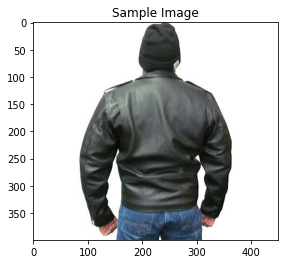

spun white white kenneth kenneth kenneth ’


In [42]:
get_prediction(test_data_loader)